# Postprocess SWAT Simulations with SQLite and Pandas (1) - Runoff

[SQL](https://en.wikipedia.org/wiki/SQL) is a domain-specific language used in programming and designed for managing data held in a relational database management system (RDBMS), or for stream processing in a relational data stream management system (RDSMS). It is particularly useful in handling structured data where there are relations between different entities/variables of the data. SQL was also a go-to tool when you needed to get a quick-and-dirty look at some data, and draw preliminary conclusions that might, eventually, lead to a report or an application being written.

[SQLite](https://www.sqlite.org/about.html) is an in-process library that implements a self-contained, serverless, zero-configuration, transactional SQL database engine.SQLite is the most widely deployed database in the world with more applications than we can count. It is great that SQLite understands most of the standard SQL language. Most programming languages and environments have good support for working with SQLite databases. Python is no exception, and a library to access SQLite databases, called sqlite3.

In this notebook, we will walk through how to use sqlite3 to query databases. We'll also cover how to simplify working with SQLite databases using the pandas package. As mentioned in the tutorial of [A Toolchain for Training Hydrological Modeling under Climate Change based on SWAT](https://www.linkedin.com/pulse/toolchain-training-hydrological-modeling-under-climate-chonghua-yin/), we know that SWAT simulations are managed by the tool of [SWAT Output Viewer](https://swatviewer.com/), which stores all data in SQLite databases. Now we take the runoff data in these databases as an example.

*It is worth noting that all data in this series are fake data and only are used to show how to postprocess SWAT simulations through open source tools.*

## 1. Load all needed libraries

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## 2. Use pandas to read SQLite database

### 2.1 Create a db connection

In [2]:
con = sqlite3.connect('data\\baseline\\result_664_monthly.db3')
cursor = con.cursor()

### 2.2 Check table names

Here we take the **RCH** table as an example

In [3]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[(u'rch',), (u'hru',), (u'sub',), (u'sed',), (u'watershed_daily',), (u'watershed_monthly',), (u'watershed_yearly',), (u'channel_dimension',), (u'hru_info',), (u'sub_info',), (u'rch_info',), (u'ave_plant',), (u'ave_annual_hru',), (u'ave_monthly_basin',), (u'ave_annual_basin',)]


### 2.3 Check columns of the RCH table

In [4]:
def table_columns(db, table_name):
    curs = db.cursor()
    sql = "select * from %s where 1=0;" % table_name
    curs.execute(sql)
    return [d[0] for d in curs.description]

In [5]:
table_columns(con, 'rch')

['RCH',
 'YR',
 'MO',
 'FLOW_INcms',
 'FLOW_OUTcms',
 'EVAPcms',
 'TLOSScms',
 'SED_INtons',
 'SED_OUTtons',
 'SEDCONCmg_kg',
 'ORGN_INkg',
 'ORGN_OUTkg',
 'ORGP_INkg',
 'ORGP_OUTkg',
 'NO3_INkg',
 'NO3_OUTkg',
 'NH4_INkg',
 'NH4_OUTkg',
 'NO2_INkg',
 'NO2_OUTkg',
 'MINP_INkg',
 'MINP_OUTkg',
 'CHLA_INkg',
 'CHLA_OUTkg',
 'CBOD_INkg',
 'CBOD_OUTkg',
 'DISOX_INkg',
 'DISOX_OUTkg',
 'SOLPST_INmg',
 'SOLPST_OUTmg',
 'SORPST_INmg',
 'SORPST_OUTmg',
 'REACTPSTmg',
 'VOLPSTmg',
 'SETTLPSTmg',
 'RESUSP_PSTmg',
 'DIFFUSEPSTmg',
 'REACBEDPSTmg',
 'BURYPSTmg',
 'BED_PSTmg',
 'BACTP_OUTct',
 'BACTLP_OUTct',
 'CMETAL_1kg',
 'CMETAL_2kg',
 'CMETAL_3kg',
 'TOT_Nkg',
 'TOT_Pkg',
 'NO3ConcMg_l',
 'WTMPdegc']

### 2.4 Read specified columns of RCH table inot a pandas DataFrame
e.g., Reach ID, Year, Month and Flow-out

In [6]:
df = pd.read_sql_query("SELECT RCH, YR, MO, FLOW_OUTcms from rch", con)
df = df.set_index(['MO'])
print(df.head(10))

    RCH    YR  FLOW_OUTcms
MO                        
1     1  1981   146.252487
1     2  1981    96.182854
1     3  1981    11.861368
1     4  1981    49.406513
1     5  1981   272.106018
1     6  1981   486.318573
1     7  1981    23.289026
1     8  1981   214.281433
1     9  1981   193.491211
1    10  1981    53.856945


### 2.5 Finally, do not forget to close the db connection

In [7]:
con.close()

## 3. Further process flow data with pandas

### 3.1 Custom quarters definition

In [8]:
quarters = {1: 'DJF', 2: 'DJF', 3: 'MAM', 4: 'MAM', 5: 'MAM', 6: 'JJA',
            7: 'JJA', 8: 'JJA', 9: 'SON', 10: 'SON', 11: 'SON', 12: 'DJF'}

### 3.2 Carry out seasonal statistics for each reach

In [9]:
ssndf = df.groupby(['RCH',quarters])['FLOW_OUTcms'].mean()
ssndf.head(5)

RCH     
1    DJF      99.204991
     JJA    1405.262298
     MAM     559.746932
     SON     454.737985
2    DJF      56.328539
Name: FLOW_OUTcms, dtype: float64

In [10]:
ssndf = ssndf.reset_index()
ssndf.set_index(['RCH'])
ssndf.head(5)

RCH level_1  FLOW_OUTcms
0    1     DJF    99.204991
1    1     JJA  1405.262298
2    1     MAM   559.746932
3    1     SON   454.737985
4    2     DJF    56.328539

In [11]:
ssndf = ssndf.rename(index=str, columns={"level_1":"SSN"})
ssndf.head(5)

RCH  SSN  FLOW_OUTcms
0    1  DJF    99.204991
1    1  JJA  1405.262298
2    1  MAM   559.746932
3    1  SON   454.737985
4    2  DJF    56.328539

In [12]:
pivoted = ssndf.pivot(index='RCH', columns='SSN', values='FLOW_OUTcms')
pivoted.head()

SSN         DJF          JJA          MAM         SON
RCH                                                  
1     99.204991  1405.262298   559.746932  454.737985
2     56.328539   773.664280   203.242828  297.934326
3     32.838328   166.310382   379.771358   27.425488
4     28.384519   619.184517   278.996801  155.766145
5    336.824441  1635.518864  1215.423962  499.265579

## 4. Visualize

Set some parameters to make figure pretty

In [13]:
# Plot size to 15" x 7"
matplotlib.rc('figure', figsize = (15, 7))
# Font size to 14
matplotlib.rc('font', size = 14)
# Display top and right frame lines
matplotlib.rc('axes.spines', top = True, right = True)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')

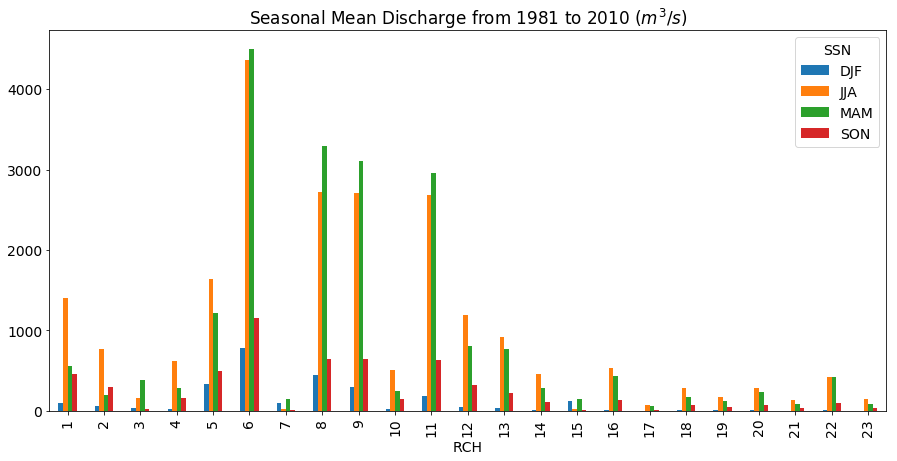

In [14]:
pivoted.plot(kind='bar', title='Seasonal Mean Discharge from 1981 to 2010 ($m^3/s$)')

## References

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Wes McKinney. Data Structures for Statistical Computing in Python, Proceedings of the 9th Python in Science Conference, 51-56 (2010)

https://www.sqlite.org/lang.html